 # Python Practice for KMP (adaptation)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from copy import copy
from utils import (load_letter_all, split_indices, preprocess_demo, denormalize,
                   rmse, endpoint_err, jerk_score, timer, append_csv)

#################################################<br>
Load the training data<br>
#################################################

In [16]:
# === KMP 公共：核函数、参考分布、目录 ===
import os, numpy as np
from utils import (load_letter_all, split_indices, denormalize,
                   rmse, endpoint_err, jerk_score, timer, append_csv)

os.makedirs('results', exist_ok=True)
os.makedirs('figs', exist_ok=True)

def rbf_kernel(t1, t2, length=0.06):
    t1 = np.asarray(t1).reshape(-1,1)
    t2 = np.asarray(t2).reshape(-1,1)
    d2 = (t1 - t2.T)**2
    return np.exp(-0.5 * d2 / (length**2))

def build_ref_from_train(preps_train):
    """训练集 → 参考分布 μ(t)、逐时刻方差 var(t)，按 (2,T) 返回"""
    stack = np.stack([p['pos'] for p in preps_train], axis=0)  # (H,2,T)
    mu  = stack.mean(axis=0)                                   # (2,T)
    var = stack.var(axis=0) + 1e-8                             # (2,T)
    return mu, var

# 全局参数（按需改）
LETTERS = ['A','B','G','H']
T       = 200
LENGTH  = 0.06
LAM     = 1e-4

In [18]:
mat = loadmat('../2Dletters/refG.mat') # The reference trajectory is extracted from five demonstrations uisng GMM/GMR
dim = 2  # 2D trajectory
Dim = 2 * dim # both position and velocity
len = mat['refTraj'].shape[1] # length of the reference trajectory

In [19]:
ref_t = np.zeros(len) # input of the reference trajectory
ref_mu = np.zeros((Dim, len)) # mean of the reference trajectory
ref_cov = np.zeros((Dim, Dim*len)) # covariance of the reference trajectory
for i in range(len):
    ref_t[i] = mat['refTraj'][0, i]['t']
    ref_mu[:, i] = mat['refTraj'][0, i]['mu'][:, 0]
    ref_cov[:, i*Dim:(i+1)*Dim] = mat['refTraj'][0, i]['sigma']
print(ref_t.shape)
print(ref_mu.shape)
print(ref_cov.shape)

(200,)
(4, 200)
(4, 800)


#################################################<br>
Define variables and set parameters for KMP<br>
#################################################

In [20]:
dt = 0.005 # time interval
tau = dt * len # motion duration
lb = 1  # regularization parameter
kh = 4  # kernel parameter

#################################################<br>
Kernel function<br>
#################################################

In [21]:
def kernel(x1, x2, kh):
    return np.exp(-kh * np.dot(x1-x2, x1-x2))

In [22]:
def kernel_extend(ta, tb, kh, dim):
    kt_t = kernel(ta, tb, kh)
    kt_dt = (kernel(ta, tb+dt, kh) - kernel(ta, tb, kh)) / dt
    kdt_t = (kernel(ta+dt, tb, kh) - kernel(ta, tb, kh)) / dt
    kdt_dt = (kernel(ta+dt, tb+dt, kh) - kernel(ta, tb+dt, kh) - kernel(ta+dt, tb, kh) + kernel(ta, tb, kh)) / dt**2
    kernelMatrix=np.zeros((Dim, Dim))
    for i in range(dim):
        kernelMatrix[i, i] = kt_t
        kernelMatrix[i, i+dim] = kt_dt
        kernelMatrix[i+dim, i] = kdt_t
        kernelMatrix[i+dim, i+dim] = kdt_dt
    return kernelMatrix

In [23]:
def kmp_insertPoint(new_ref_t, new_ref_mu, new_ref_cov, via_time, via_point, via_var):
    replaceFlag = 0
    # Judge whether there is a point in the reference trajectory which is close to the desired point
    for i in range(new_ref_t.shape[0]):
        if np.abs(new_ref_t[i] - via_time) < 5E-4:
            replaceFlag = 1
            index = i
            break
    # Replace the nearest point in the reference trajectory with the desired point
    if  replaceFlag == 1:
        new_ref_t[index] = via_time
        new_ref_mu[:, index] = via_point
        new_ref_cov[:, index*Dim:(index+1)*Dim] = via_var
    # Concatenate the desired point with the reference trajectory
    else:
        new_ref_t = np.hstack((new_ref_t, via_time))
        new_ref_mu = np.hstack((new_ref_mu, via_point.reshape(Dim, 1)))
        new_ref_cov = np.hstack((new_ref_cov, via_var))
    return new_ref_t, new_ref_mu, new_ref_cov

#########################################################<br>
Define desired points and update the reference trajectory<br>
#########################################################

In [24]:
via_time1 = dt
via_point1 = np.array([8, 10, -50, 0]) # first desired point, format:[2D pos, 2D vel]
via_time2 = 0.6
via_point2 = np.array([8, -4, 30, 10]) # second desired point, format:[2D pos, 2D vel]
via_time3 = 1.0
via_point3 = np.array([-3, 1, -10, 3]) # third desired point, format:[2D pos, 2D vel]

In [25]:
via_var = 1E-6 * np.eye(Dim) # inversely proportional to the adaptation precision
# via_var[2, 2] = 1000 # a large error is allowed for vx
# via_var[3, 3] = 1000 # a large error is allowed for vy

Determine the new probabilistic reference trajectory

In [26]:
new_ref_t = copy(ref_t)
new_ref_mu = copy(ref_mu)
new_ref_cov = copy(ref_cov)
[new_ref_t, new_ref_mu, new_ref_cov] = kmp_insertPoint(new_ref_t, new_ref_mu, new_ref_cov, via_time1, via_point1, via_var)
[new_ref_t, new_ref_mu, new_ref_cov] = kmp_insertPoint(new_ref_t, new_ref_mu, new_ref_cov, via_time2, via_point2, via_var)
[new_ref_t, new_ref_mu, new_ref_cov] = kmp_insertPoint(new_ref_t, new_ref_mu, new_ref_cov, via_time3, via_point3, via_var)

#################################################<br>
Prediction using KMP<br>
#################################################

In [27]:
new_len = new_ref_t.shape[0]
Kc = np.zeros((new_len*Dim, new_len*Dim))
for i in range(new_len):
    for j in range(new_len):
        Kc[i*Dim:(i+1)*Dim, j*Dim:(j+1)*Dim] = kernel_extend(new_ref_t[i], new_ref_t[j], kh, dim)
        if i == j:
            Kc[i*Dim:(i+1)*Dim, j*Dim:(j+1)*Dim] += lb * new_ref_cov[:, i*Dim:(i+1)*Dim]

In [28]:
Kinv = np.linalg.pinv(Kc)
Mu = new_ref_mu.flatten(order='F')
KinvMu = np.matmul(Kinv, Mu) # (Kc+lb*Sigma)^{-1}*Mu

In [29]:
ks = np.zeros((Dim, Dim*new_len))
pred_pv = np.zeros((Dim, len))
for i in range(len):
    t = (i+1) * dt
    for j in range(new_len):
        ks[:, j*Dim:(j+1)*Dim] = kernel_extend(t, new_ref_t[j], kh, dim)
    pred_pv[:, i] = np.matmul(ks, KinvMu) # ks*(Kc+lb*Sigma)^{-1}*Mu

#################################################<br>
Plot predicted trajectories<br>
#################################################-

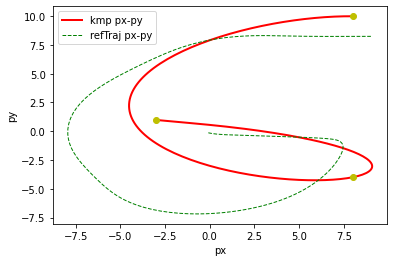

In [30]:
plt.plot(pred_pv[0], pred_pv[1], 'r', label='kmp px-py', linewidth=2)
plt.plot(ref_mu[0, :], ref_mu[1, :], 'g--', linewidth=1, label='refTraj px-py')
plt.plot(via_point1[0], via_point1[1], 'yo')
plt.plot(via_point2[0], via_point2[1], 'yo')
plt.plot(via_point3[0], via_point3[1], 'yo')
plt.xlabel("px")
plt.ylabel("py")
plt.legend()
plt.show()

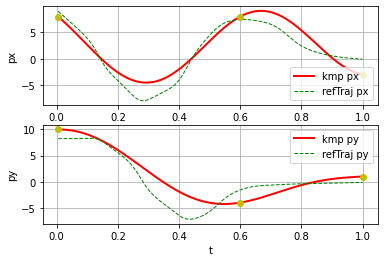

In [31]:
ax1 = plt.subplot(2, 1, 1)
ax1.plot(ref_t, pred_pv[0], 'r', label='kmp px', linewidth=2)
ax1.plot(ref_t, ref_mu[0, :], 'g--', linewidth=1, label='refTraj px')
plt.plot(via_time1, via_point1[0], 'yo')
plt.plot(via_time2, via_point2[0], 'yo')
plt.plot(via_time3, via_point3[0], 'yo')
ax1.set_ylabel("px")
plt.legend()
ax1.grid()
ax2 = plt.subplot(2, 1, 2)
ax2.plot(ref_t, pred_pv[1], 'r', label='kmp py', linewidth=2)
ax2.plot(ref_t, ref_mu[1, :], 'g--', linewidth=1, label='refTraj py')
plt.plot(via_time1, via_point1[1], 'yo')
plt.plot(via_time2, via_point2[1], 'yo')
plt.plot(via_time3, via_point3[1], 'yo')
ax2.set_ylabel("py")
ax2.set_xlabel("t")
plt.legend()
ax2.grid()
plt.show()

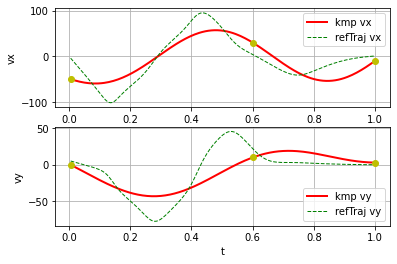

In [32]:
ax1 = plt.subplot(2, 1, 1)
ax1.plot(ref_t, pred_pv[2], 'r', label='kmp vx', linewidth=2)
ax1.plot(ref_t, ref_mu[2, :], 'g--', linewidth=1, label='refTraj vx')
plt.plot(via_time1, via_point1[2], 'yo')
plt.plot(via_time2, via_point2[2], 'yo')
plt.plot(via_time3, via_point3[2], 'yo')
ax1.set_ylabel("vx")
plt.legend()
ax1.grid()
ax2 = plt.subplot(2, 1, 2)
ax2.plot(ref_t, pred_pv[3], 'r', label='kmp vy', linewidth=2)
ax2.plot(ref_t, ref_mu[3, :], 'g--', linewidth=1, label='refTraj vy')
plt.plot(via_time1, via_point1[3], 'yo')
plt.plot(via_time2, via_point2[3], 'yo')
plt.plot(via_time3, via_point3[3], 'yo')
ax2.set_ylabel("vy")
ax2.set_xlabel("t")
plt.legend()
ax2.grid()
plt.show()

In [20]:
# === A. KMP / U-KMP : LOO reproduction ===
from utils import denormalize  # 可能上面已导入，这里确保可用

def kmp_predict_1d(mu_d, var_d, t_ref, t_query, length=LENGTH, lam=LAM, use_u=False):
    K_rr = rbf_kernel(t_ref,   t_ref,   length)
    K_qr = rbf_kernel(t_query, t_ref,   length)
    if use_u:
        R = lam * np.diag(var_d)           # U-KMP：不确定性感知
    else:
        R = lam * np.eye(len(t_ref))       # KMP：常数正则
    alpha = np.linalg.solve(K_rr + R, mu_d)
    return K_qr @ alpha

csv_header = ['method','letter','fold','rmse','end_err','jerk','train_ms','infer_ms']
csv_kmp    = 'results/reproduction_LOO_kmp_ada.csv'
csv_ukmp   = 'results/reproduction_LOO_ukmp_ada.csv'

for letter in LETTERS:
    preps = load_letter_all(letter, T=T, norm='zscore')
    N = len(preps)
    print(f'[KMP-repro:{letter}] demos={N}')
    for fold in range(N):
        tr_idx, te_idx = split_indices(N, mode='loo', loo_test=fold)
        preps_tr = [preps[i] for i in tr_idx]
        prep_te  = preps[te_idx[0]]

        with timer() as t_train:
            mu, var = build_ref_from_train(preps_tr)  # (2,T)
            t_ref = np.linspace(0,1,mu.shape[1])
        train_ms = t_train()

        t_q = np.linspace(0,1,prep_te['pos'].shape[1])

        # KMP
        with timer() as t_infer:
            y_pred_n = np.vstack([
                kmp_predict_1d(mu[0], var[0], t_ref, t_q, LENGTH, LAM, use_u=False),
                kmp_predict_1d(mu[1], var[1], t_ref, t_q, LENGTH, LAM, use_u=False)
            ])
        infer_ms = t_infer()
        y_pred = denormalize(y_pred_n, prep_te['stats'])
        y_true = denormalize(prep_te['pos'], prep_te['stats'])
        m = rmse(y_true, y_pred); e = endpoint_err(y_true, y_pred); j = jerk_score(y_pred, prep_te['dt'])
        append_csv(csv_kmp,  csv_header, ['KMP',  letter, fold, m, e, j, train_ms, infer_ms])

        # U-KMP
        with timer() as t_infer2:
            y_pred_n2 = np.vstack([
                kmp_predict_1d(mu[0], var[0], t_ref, t_q, LENGTH, LAM, use_u=True),
                kmp_predict_1d(mu[1], var[1], t_ref, t_q, LENGTH, LAM, use_u=True)
            ])
        infer_ms2 = t_infer2()
        y_pred2 = denormalize(y_pred_n2, prep_te['stats'])
        m2 = rmse(y_true, y_pred2); e2 = endpoint_err(y_true, y_pred2); j2 = jerk_score(y_pred2, prep_te['dt'])
        append_csv(csv_ukmp, csv_header, ['U-KMP', letter, fold, m2, e2, j2, train_ms, infer_ms2])

        print(f'  fold={fold:02d} | KMP  RMSE={m:.4f} end={e:.4f} jerk={j:.4f} '
              f'|| U-KMP RMSE={m2:.4f} end={e2:.4f} jerk={j2:.4f}')
print('Done ->', csv_kmp, 'and', csv_ukmp)

[KMP-repro:A] demos=10
  fold=00 | KMP  RMSE=3.2197 end=0.9875 jerk=30368.6980 || U-KMP RMSE=3.2197 end=0.9920 jerk=30425.2620
  fold=01 | KMP  RMSE=0.6412 end=0.7877 jerk=25013.3211 || U-KMP RMSE=0.6410 end=0.7822 jerk=24843.6552
  fold=02 | KMP  RMSE=0.5203 end=0.6805 jerk=25733.2005 || U-KMP RMSE=0.5203 end=0.6841 jerk=25515.8777
  fold=03 | KMP  RMSE=0.3953 end=0.0771 jerk=25353.2504 || U-KMP RMSE=0.3950 end=0.0731 jerk=25195.4625
  fold=04 | KMP  RMSE=0.6313 end=0.3927 jerk=25229.3543 || U-KMP RMSE=0.6312 end=0.3930 jerk=25005.0578
  fold=05 | KMP  RMSE=0.4721 end=0.1328 jerk=22347.7153 || U-KMP RMSE=0.4721 end=0.1297 jerk=22254.3654
  fold=06 | KMP  RMSE=0.5382 end=0.2211 jerk=24444.7773 || U-KMP RMSE=0.5384 end=0.2172 jerk=24373.9736
  fold=07 | KMP  RMSE=1.5621 end=0.0753 jerk=25528.0377 || U-KMP RMSE=1.5622 end=0.0732 jerk=25215.1909
  fold=08 | KMP  RMSE=0.5075 end=0.9160 jerk=25277.7504 || U-KMP RMSE=0.5074 end=0.9224 jerk=25092.7589
  fold=09 | KMP  RMSE=0.5354 end=1.1042 j

In [22]:
# === B. KMP / U-KMP : Missing (prefix) completion ===
p_list     = [0.6, 0.4]  # 前 60% / 40% 作为观测
csv_miss_kmp  = 'results/missing_kmp_ada.csv'
csv_miss_ukmp = 'results/missing_ukmp_ada.csv'
csv_header    = ['method','letter','fold','p','rmse','end_err','jerk','train_ms','infer_ms']

for letter in LETTERS:
    preps = load_letter_all(letter, T=T, norm='zscore')
    N = len(preps)
    print(f'[KMP-missing:{letter}] demos={N}')
    for fold in range(N):
        tr_idx, te_idx = split_indices(N, mode='loo', loo_test=fold)
        preps_tr = [preps[i] for i in tr_idx]
        prep_te  = preps[te_idx[0]]

        with timer() as t_train:
            mu, var = build_ref_from_train(preps_tr)
            t = np.linspace(0,1,mu.shape[1])
            K = rbf_kernel(t, t, LENGTH)      # (T,T)
        train_ms = t_train()

        for p in p_list:
            L   = int(T * p)
            idx = np.arange(L)
            # 普通 KMP 条件化
            with timer() as t_infer:
                y_pred_n = np.zeros_like(prep_te['pos'])
                for d in range(2):
                    mu_d  = mu[d]
                    y_obs = prep_te['pos'][d, :L]
                    K_oo  = K[np.ix_(idx, idx)]
                    K_to  = K[:, idx]
                    R     = LAM * np.eye(L)
                    alpha = np.linalg.solve(K_oo + R, (y_obs - mu_d[idx]))
                    y_pred_n[d] = mu_d + K_to @ alpha
            infer_ms = t_infer()

            y_pred = denormalize(y_pred_n, prep_te['stats'])
            y_true = denormalize(prep_te['pos'], prep_te['stats'])
            m = rmse(y_true, y_pred); e = endpoint_err(y_true, y_pred); j = jerk_score(y_pred, prep_te['dt'])
            append_csv(csv_miss_kmp,  csv_header, ['KMP', letter, fold, p, m, e, j, train_ms, infer_ms])

            # U-KMP 条件化（观测噪声与参考方差成正比）
            with timer() as t_infer2:
                y_pred_n2 = np.zeros_like(prep_te['pos'])
                for d in range(2):
                    mu_d  = mu[d]
                    y_obs = prep_te['pos'][d, :L]
                    K_oo  = K[np.ix_(idx, idx)]
                    K_to  = K[:, idx]
                    R     = LAM * np.diag(var[d, :L])
                    alpha = np.linalg.solve(K_oo + R, (y_obs - mu_d[idx]))
                    y_pred_n2[d] = mu_d + K_to @ alpha
            infer_ms2 = t_infer2()

            y_pred2 = denormalize(y_pred_n2, prep_te['stats'])
            m2 = rmse(y_true, y_pred2); e2 = endpoint_err(y_true, y_pred2); j2 = jerk_score(y_pred2, prep_te['dt'])
            append_csv(csv_miss_ukmp, csv_header, ['U-KMP', letter, fold, p, m2, e2, j2, train_ms, infer_ms2])

            print(f'  fold={fold:02d} p={p:.1f} | KMP  RMSE={m:.4f} end={e:.4f} jerk={j:.4f} '
                  f'|| U-KMP RMSE={m2:.4f} end={e2:.4f} jerk={j2:.4f}')
print('Done ->', csv_miss_kmp, 'and', csv_miss_ukmp)

[KMP-missing:A] demos=10
  fold=00 p=0.6 | KMP  RMSE=0.8184 end=0.9921 jerk=30830.0567 || U-KMP RMSE=0.6386 end=0.9921 jerk=34902.5966
  fold=00 p=0.4 | KMP  RMSE=1.8688 end=0.9921 jerk=29028.3010 || U-KMP RMSE=2.0200 end=0.9921 jerk=34608.8289
  fold=01 p=0.6 | KMP  RMSE=0.6226 end=0.7820 jerk=37285.7114 || U-KMP RMSE=0.9236 end=0.7820 jerk=46997.2509
  fold=01 p=0.4 | KMP  RMSE=0.5074 end=0.7820 jerk=35892.1482 || U-KMP RMSE=0.6530 end=0.7820 jerk=38890.9574
  fold=02 p=0.6 | KMP  RMSE=0.9339 end=0.6850 jerk=37409.6517 || U-KMP RMSE=0.9275 end=0.6850 jerk=49050.5988
  fold=02 p=0.4 | KMP  RMSE=0.4766 end=0.6850 jerk=31262.7974 || U-KMP RMSE=0.5099 end=0.6850 jerk=33042.7003
  fold=03 p=0.6 | KMP  RMSE=0.5617 end=0.0720 jerk=37137.2020 || U-KMP RMSE=0.5604 end=0.0720 jerk=40070.6627
  fold=03 p=0.4 | KMP  RMSE=0.4898 end=0.0720 jerk=37175.2020 || U-KMP RMSE=1.7859 end=0.0720 jerk=53575.9376
  fold=04 p=0.6 | KMP  RMSE=1.0761 end=0.3930 jerk=44400.4003 || U-KMP RMSE=1.1399 end=0.3930 j

In [28]:
# === C. KMP / U-KMP : Obstacle avoidance via-point (FIXED) ===
import numpy as np
import matplotlib.pyplot as plt
from utils import (load_letter_all, split_indices, denormalize,
                   rmse, endpoint_err, jerk_score, append_csv)

# 依赖：上文已定义 rbf_kernel / build_ref_from_train / LETTERS / T / LENGTH / LAM
csv_ob_kmp  = 'results/obstacle_kmp_ada.csv'
csv_ob_ukmp = 'results/obstacle_ukmp_ada.csv'
csv_header  = ['method','letter','fold','hit_before','hit_after','rmse','end_err','jerk']

def intersects_circle(p0, p1, c, r):
    p0, p1, c = np.array(p0), np.array(p1), np.array(c)
    d = p1 - p0; f = p0 - c
    a = d.dot(d); b = 2*f.dot(d); cc = f.dot(f) - r*r
    disc = b*b - 4*a*cc
    if disc < 0: return False
    disc = np.sqrt(disc)
    t1 = (-b - disc)/(2*a); t2 = (-b + disc)/(2*a)
    return (0<=t1<=1) or (0<=t2<=1)

def make_viapoint_around(c, r, entry, inflate=1.35):
    c = np.array(c); v = entry - c
    v = v / (np.linalg.norm(v)+1e-8)
    return c + v * (r*inflate)

for letter in LETTERS:
    preps = load_letter_all(letter, T=T, norm='zscore')
    N = len(preps)
    print(f'[KMP-obstacle:{letter}] demos={N}')
    for fold in range(N):
        tr_idx, te_idx = split_indices(N, mode='loo', loo_test=fold)
        preps_tr = [preps[i] for i in tr_idx]
        prep_te  = preps[te_idx[0]]

        # 参考分布 & 核
        mu, var = build_ref_from_train(preps_tr)     # (2,T)
        t = np.linspace(0,1,mu.shape[1])
        K = rbf_kernel(t, t, LENGTH)                 # (T,T)

        # 初始预测（普通 KMP）
        y_pred_n = np.zeros_like(prep_te['pos'])
        for d in range(2):
            mu_d = mu[d]
            alpha = np.linalg.solve(K + LAM*np.eye(T), mu_d.reshape(-1))
            y_pred_n[d] = (K @ alpha).reshape(-1)
        y_pred = denormalize(y_pred_n, prep_te['stats'])
        y_true = denormalize(prep_te['pos'], prep_te['stats'])

        # 非归一化尺度下设置圆障碍（放在字母中心）
        xmin, xmax = y_true[0].min(), y_true[0].max()
        ymin, ymax = y_true[1].min(), y_true[1].max()
        c_den = np.array([(xmin+xmax)/2, (ymin+ymax)/2])
        r_den = 0.25 * max(xmax-xmin, ymax-ymin)

        def any_hit(path):
            for i in range(path.shape[1]-1):
                if intersects_circle(path[:, i], path[:, i+1], c_den, r_den):
                    return True
            return False

        hit_before = any_hit(y_pred)

        if hit_before:
            # 最近侵入点 -> 生成圆外 via-point
            dists = np.linalg.norm(y_pred.T - c_den, axis=1)  # (T,)
            idx = int(np.argmin(dists))
            entry = y_pred[:, idx]
            via_den = make_viapoint_around(c_den, r_den, entry, inflate=1.35)

            # via 映射回归一化
            mean, std = prep_te['stats']['mean'], prep_te['stats']['std']
            via_n = ((via_den.reshape(-1,1) - mean) / std).reshape(-1)  # (2,)
            idx_arr = np.array([idx])                                   # (1,)
            K_oo = K[np.ix_(idx_arr, idx_arr)]                          # (1,1)
            K_to = K[:, idx_arr]                                        # (T,1)

            # --- KMP 条件化（单点 via）---
            y_pred_n2 = np.zeros_like(prep_te['pos'])
            for d in range(2):
                mu_d = mu[d].reshape(-1)                                # (T,)
                # 右端项 b 必须是列向量 (1,1)
                b = (via_n[d] - mu_d[idx]).reshape(1,1)                 # (1,1)
                alpha = np.linalg.solve(K_oo + LAM*np.eye(1), b).reshape(-1)   # (1,)
                y_pred_n2[d] = (mu_d + (K_to @ alpha).reshape(-1))      # (T,)
            y_pred2 = denormalize(y_pred_n2, prep_te['stats'])
            hit_after = any_hit(y_pred2)

            m = rmse(y_true, y_pred2); e = endpoint_err(y_true, y_pred2); j = jerk_score(y_pred2, prep_te['dt'])
            append_csv(csv_ob_kmp, csv_header, ['KMP', letter, fold, int(hit_before), int(hit_after), m, e, j])

            # --- U-KMP（方差加权噪声）---
            y_pred_n3 = np.zeros_like(prep_te['pos'])
            sig = float(var[:, idx].mean())                              # 取两维方差均值
            for d in range(2):
                mu_d = mu[d].reshape(-1)
                b = (via_n[d] - mu_d[idx]).reshape(1,1)                  # (1,1)
                alpha = np.linalg.solve(K_oo + LAM*np.diag([sig]), b).reshape(-1)
                y_pred_n3[d] = (mu_d + (K_to @ alpha).reshape(-1))
            y_pred3 = denormalize(y_pred_n3, prep_te['stats'])
            hit_after_u = any_hit(y_pred3)
            m3 = rmse(y_true, y_pred3); e3 = endpoint_err(y_true, y_pred3); j3 = jerk_score(y_pred3, prep_te['dt'])
            append_csv(csv_ob_ukmp, csv_header, ['U-KMP', letter, fold, int(hit_before), int(hit_after_u), m3, e3, j3])

            # 可视化保存
            plt.figure(figsize=(4.2,4.2))
            plt.plot(y_true[0], y_true[1], 'k--', lw=1, label='GT')
            plt.plot(y_pred[0], y_pred[1], 'b:', lw=1, label='before')
            plt.plot(y_pred2[0], y_pred2[1], 'g-', lw=2, label='KMP after')
            circle = plt.Circle(c_den, r_den, color='r', fill=False, lw=2)
            plt.gca().add_patch(circle)
            plt.scatter([via_den[0]],[via_den[1]], c='orange', s=30, label='via')
            plt.gca().set_aspect('equal'); plt.title(f'{letter} fold{fold} obstacle')
            plt.legend(frameon=False); plt.tight_layout()
            plt.savefig(f'figs/kmp_obstacle_{letter}_fold{fold}.png', dpi=200); plt.close()

        else:
            # 未命中也记录（after=0）
            m = rmse(y_true, y_pred); e = endpoint_err(y_true, y_pred); j = jerk_score(y_pred, prep_te['dt'])
            append_csv(csv_ob_kmp,  csv_header, ['KMP',  letter, fold, 0, 0, m, e, j])
            append_csv(csv_ob_ukmp, csv_header, ['U-KMP', letter, fold, 0, 0, m, e, j])

print('Obstacle avoidance done ->', csv_ob_kmp, 'and', csv_ob_ukmp)

[KMP-obstacle:A] demos=10
[KMP-obstacle:B] demos=12
[KMP-obstacle:G] demos=13
[KMP-obstacle:H] demos=13
Obstacle avoidance done -> results/obstacle_kmp_ada.csv and results/obstacle_ukmp_ada.csv
